# Prepare GPX File for RGT Magic Road Upload

Use gpxpy for loading GPX File

https://pypi.org/project/gpxpy/

## SRTM Data

https://github.com/tkrajina/srtm.py

Also consider https://gpx-converter.readthedocs.io/en/latest/ for handling GPX data

In [328]:
#!pip install gpxpy --upgrade
#!pip install SRTM.py --upgrade

## Test Data File: Hockenheimring Motor Racing Circuit

This is a track I recorded running a 5k race on 1 November, 2019 using a Garmin Vivoactive 3 watch. The event was the annual Hockenheimringlauf organized by the local triathon club. It even took place in November 2020 under higly restricted pandemic conditions: I did not take pare. With luck, it may take place again normally in 2021.

https://www.asgtria-hockenheim.de/hockenheim-lauf/ 

Wikipedia article on the race track:

https://en.wikipedia.org/wiki/Hockenheimring

I performed basic pruning and straightening of a few obvious outliers in Garmin Basecamp.


In [329]:
import gpxpy
import gpxpy.gpx

# Parsing an existing file:
# -------------------------

gpx_file = open('hockenheimring-magic-road.GPX', 'r')

gpx = gpxpy.parse(gpx_file)

#for track in gpx.tracks:
#    for segment in track.segments:
#        for point in segment.points:
#            pass
           # print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

gpx_points = gpx.tracks[0].segments[0].points # There is only one segment in the GPX file

print(gpx_points[0].latitude, gpx_points[0].longitude, gpx_points[0].elevation, gpx_points[0].time)

49.3273111525923 8.566147461533546 101.4000015258789 2019-11-01 08:02:12+00:00


In [330]:
import pandas as pd 

df = pd.DataFrame([[s.latitude, s.longitude, s.elevation, s.time] for s in gpx_points], columns=['latitude', 'longitude', 'elevation', 'time'])

In [331]:
df

,latitude,longitude,elevation,time
0,49.327311,8.566147,101.400002,2019-11-01 08:02:12+00:00
1,49.327339,8.566121,101.400002,2019-11-01 08:02:13+00:00
2,49.327369,8.566092,101.400002,2019-11-01 08:02:14+00:00
3,49.327401,8.566064,101.400002,2019-11-01 08:02:15+00:00
4,49.327434,8.566033,101.400002,2019-11-01 08:02:16+00:00
...,...,...,...,...
1150,49.327044,8.566352,107.000000,2019-11-01 08:21:41+00:00
1151,49.327081,8.566322,107.000000,2019-11-01 08:21:43+00:00
1152,49.327119,8.566293,107.000000,2019-11-01 08:21:44+00:00
1153,49.327220,8.566217,107.000000,2019-11-01 08:21:47+00:00


<AxesSubplot:xlabel='longitude'>

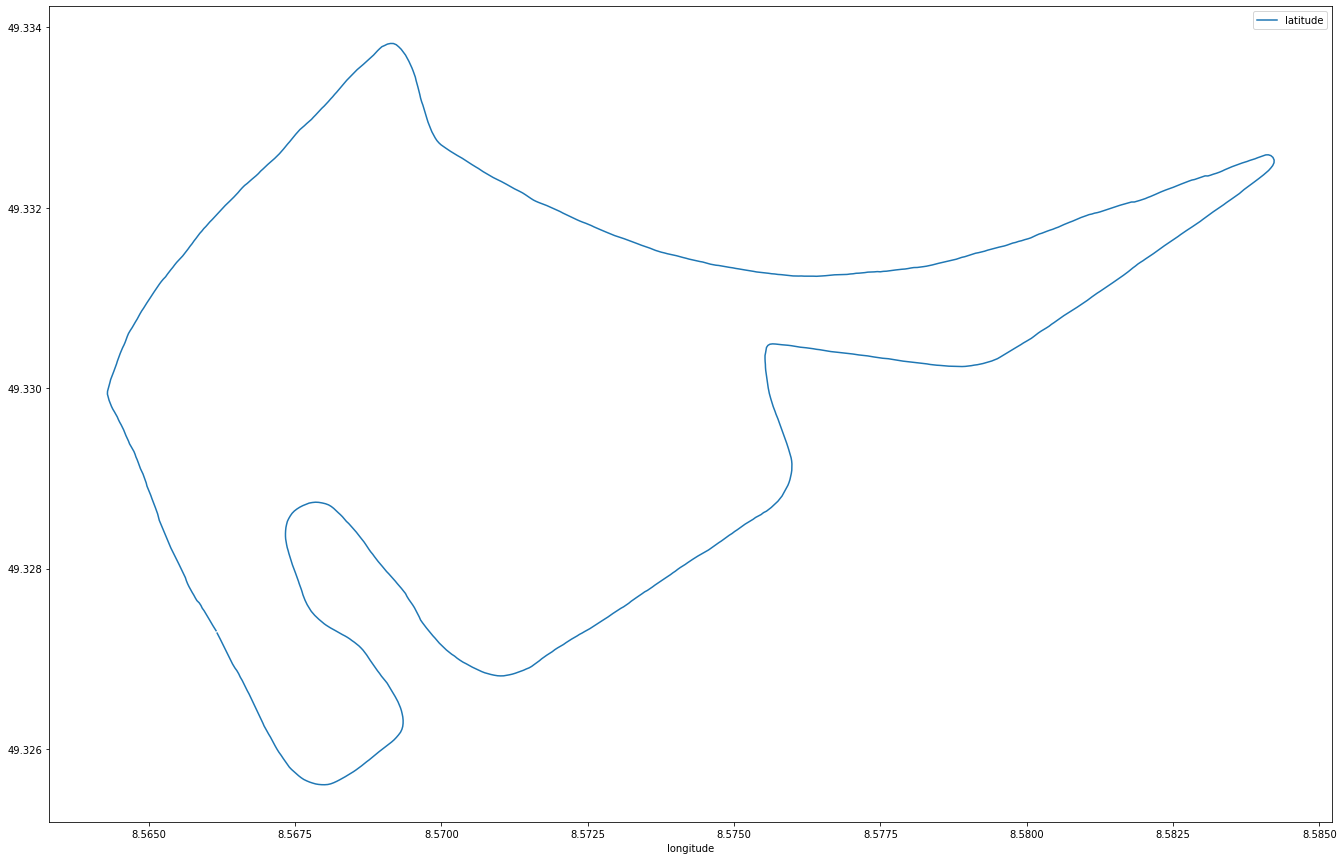

In [332]:
df.plot(x='longitude', y='latitude', figsize=[23, 15])

## Use SRTM data for elevation corrections

Structures on and around the track, such as the spectator stands may cause the SRTM data to be inaccurate

In [333]:
import srtm
elevation_data = srtm.get_data(local_cache_dir="srtmcache") # Cache data so it does not need to be downloaded every time

In [334]:
print(elevation_data.get_elevation(df.iloc[0].latitude, df.iloc[0].longitude))

108


In [335]:
df['srtm_ele'] = df.apply(lambda x: elevation_data.get_elevation(x['latitude'], x['longitude']), axis=1)

In [336]:
elevation_data.add_elevations(gpx, only_missing=False, smooth=True) # See if the built-in elevation function helps

In [337]:
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            pass # doesn't seem to really help
#            print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

print(min(pnt.elevation for pnt in gpx.tracks[0].segments[0].points), max(pnt.elevation for pnt in gpx.tracks[0].segments[0].points))

df['srtm_ele_built_in_smooth'] = list(pnt.elevation for pnt in gpx.tracks[0].segments[0].points)
df

99.04567826331412 118.85384264459827


,latitude,longitude,elevation,time,srtm_ele,srtm_ele_built_in_smooth
0,49.327311,8.566147,101.400002,2019-11-01 08:02:12+00:00,108,108.000000
1,49.327339,8.566121,101.400002,2019-11-01 08:02:13+00:00,108,107.705818
2,49.327369,8.566092,101.400002,2019-11-01 08:02:14+00:00,108,107.391396
3,49.327401,8.566064,101.400002,2019-11-01 08:02:15+00:00,108,107.060313
4,49.327434,8.566033,101.400002,2019-11-01 08:02:16+00:00,108,106.714673
...,...,...,...,...,...,...
1150,49.327044,8.566352,107.000000,2019-11-01 08:21:41+00:00,108,107.236600
1151,49.327081,8.566322,107.000000,2019-11-01 08:21:43+00:00,108,107.357124
1152,49.327119,8.566293,107.000000,2019-11-01 08:21:44+00:00,108,107.476891
1153,49.327220,8.566217,107.000000,2019-11-01 08:21:47+00:00,108,107.795615


### Compare Raw SRTM with Original Raw and Both Smoothed

Note the orginal data ends about 5 metres higher than the start point. Presumably this is due to the innacurate barmometric pressure monitor on the Garmin watch. Body heat which rises significantly during the run may account for this.

The RGT magic road processor corrects this on uploaded files. Based on my tests and remembered experience of running the track, the smoothed original data is a better representation of the circuit.

Savitzky-Golay filter seems to do better (see https://stackoverflow.com/a/51841715), https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html 

<AxesSubplot:>

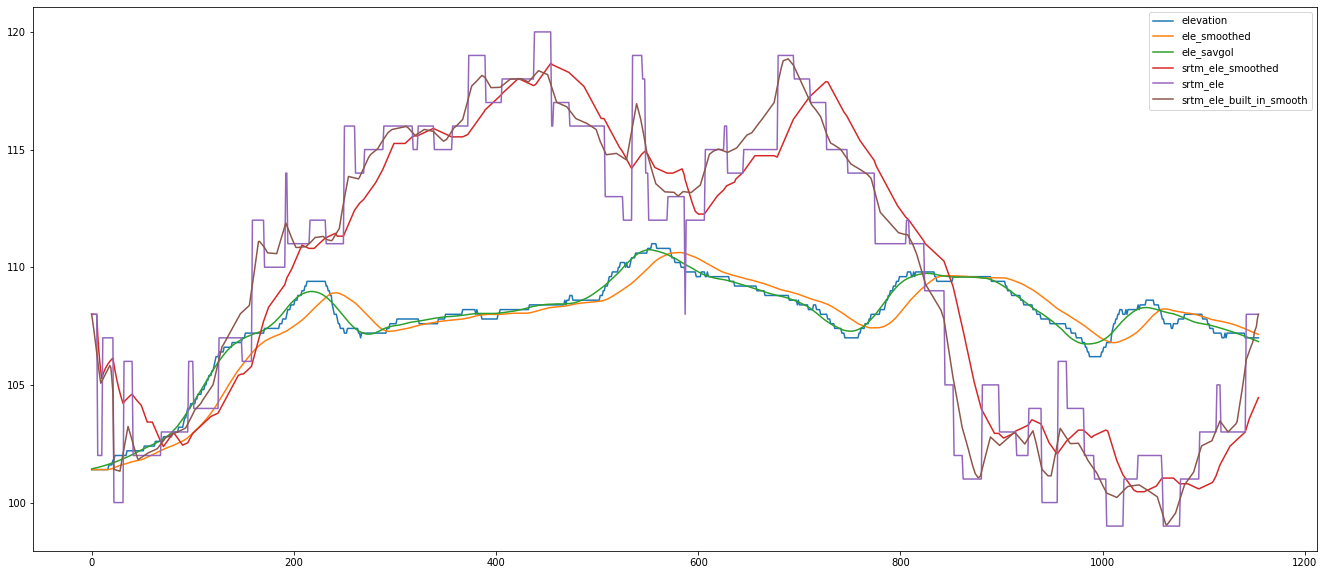

In [338]:
df['srtm_ele_smoothed'] = df['srtm_ele'].rolling(window=50, min_periods=1).mean()
df['ele_smoothed'] = df['elevation'].rolling(window=50, min_periods=1).mean()

from scipy.signal import savgol_filter
df['ele_savgol'] = savgol_filter(df['elevation'], 101, 2)

# Compare original elevation with SRTM, and with both smoothed:
df[['elevation', 'ele_smoothed', 'ele_savgol', 'srtm_ele_smoothed', 'srtm_ele', 'srtm_ele_built_in_smooth']].plot(figsize=[23, 10])

## Smooth GPS Coordinates - Various Approaches

Use Kalman Filter to smooth GPS coordinates: https://stackoverflow.com/questions/48739169/how-to-apply-a-rolling-kalman-filter-to-a-column-in-a-dataframe

* https://stackoverflow.com/questions/43377626/how-to-use-kalman-filter-in-python-for-location-data

* https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-python

* https://stackoverflow.com/questions/37598986/reducing-noise-on-data 

Have currently settled on savgol filter. Not intended for coordinates but seems to produce reasonable disjoint latitude, longitude smoothing.


### Savitzky-Golay Filter on GPS Coordinates

Apply separately to longitude, latitude for rough smoothing.

<AxesSubplot:xlabel='lon_savgol'>

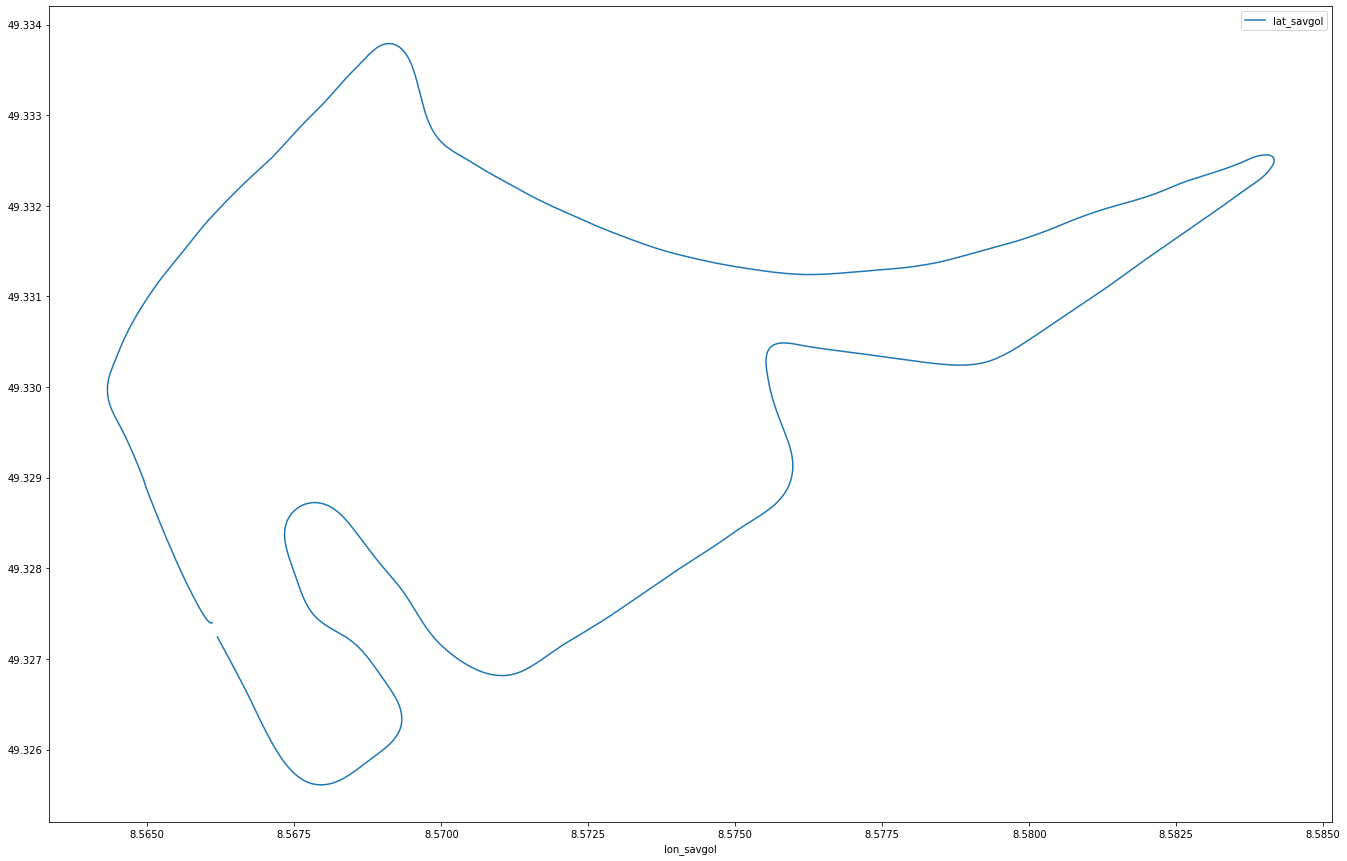

In [339]:

df['lat_savgol'] = savgol_filter(df['latitude'], 27, 2)
df['lon_savgol'] = savgol_filter(df['longitude'], 27, 2)
df.plot(x='lon_savgol', y='lat_savgol', figsize=[23, 15])

### Try Resampling to Simplify Data

In [340]:
from scipy.signal import lfilter
from scipy.interpolate import UnivariateSpline
import scipy

df[['latitude', 'longitude']]

df_resample = df.resample('5s', on='time').mean()
df_resample

,latitude,longitude,elevation,srtm_ele,srtm_ele_built_in_smooth,srtm_ele_smoothed,ele_smoothed,ele_savgol,lat_savgol,lon_savgol
time,,,,,,,,,,
2019-11-01 08:02:10+00:00,49.327340,8.566120,101.400002,108.0,107.699071,108.000000,101.400002,101.440676,49.327397,8.566091
2019-11-01 08:02:15+00:00,49.327467,8.566003,101.400002,105.6,106.364998,107.528571,101.400002,101.480875,49.327429,8.566022
2019-11-01 08:02:20+00:00,49.327618,8.565855,101.400002,104.0,105.231744,105.565571,101.400002,101.537529,49.327565,8.565885
2019-11-01 08:02:25+00:00,49.327768,8.565713,101.440001,107.0,105.571287,105.803098,101.402224,101.601574,49.327813,8.565687
2019-11-01 08:02:30+00:00,49.327883,8.565632,101.599998,107.0,105.775735,106.025000,101.425527,101.650544,49.328051,8.565514
...,...,...,...,...,...,...,...,...,...,...
2019-11-01 08:21:25+00:00,49.326542,8.566760,107.199997,103.0,104.834404,102.880000,107.435999,107.109899,49.326542,8.566759
2019-11-01 08:21:30+00:00,49.326721,8.566622,107.000000,107.0,106.150420,103.280000,107.343999,107.029935,49.326720,8.566621
2019-11-01 08:21:35+00:00,49.326886,8.566484,107.000000,108.0,106.725299,103.810000,107.254999,106.955057,49.326916,8.566463


<AxesSubplot:xlabel='longitude'>

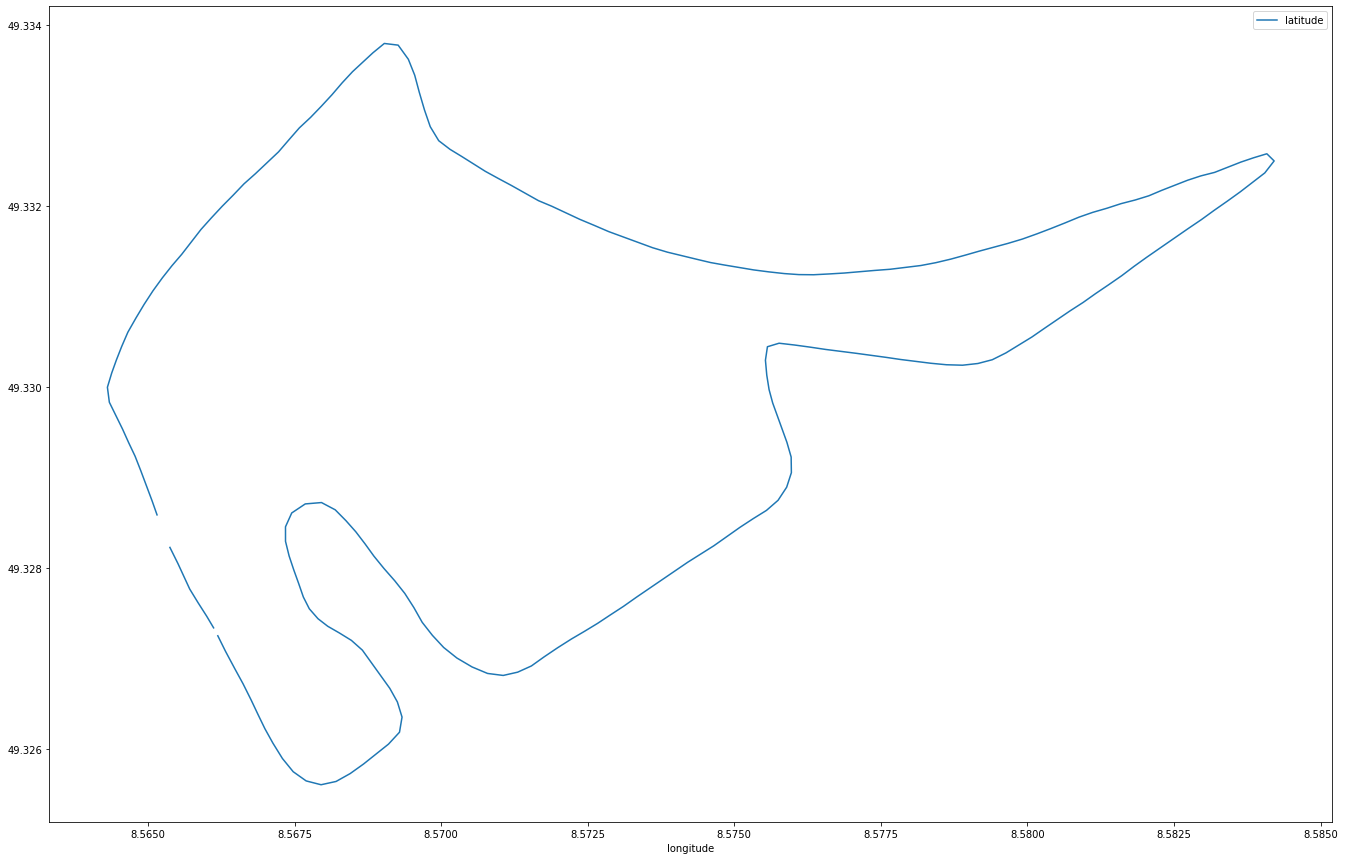

In [341]:
df_resample.plot(x='longitude', y='latitude', figsize=[23, 15])

In [342]:
df_upsample = df_resample.resample('1s').interpolate(method='linear', order=5) #.plot(x='longitude', y='latitude', figsize=[23, 15])

## Use B-Spline Smoothing of GPS Coordinates

References: 

* B-spline representation of an N-D curve: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splprep.html#scipy.interpolate.splprep

* https://stackoverflow.com/questions/13513244/smooth-a-trajectory-with-splrep?noredirect=1&lq=1

* https://en.wikipedia.org/wiki/B-spline

Appears to produce acceptable results. Smoothing of s=0.00000001 seems best compromise.


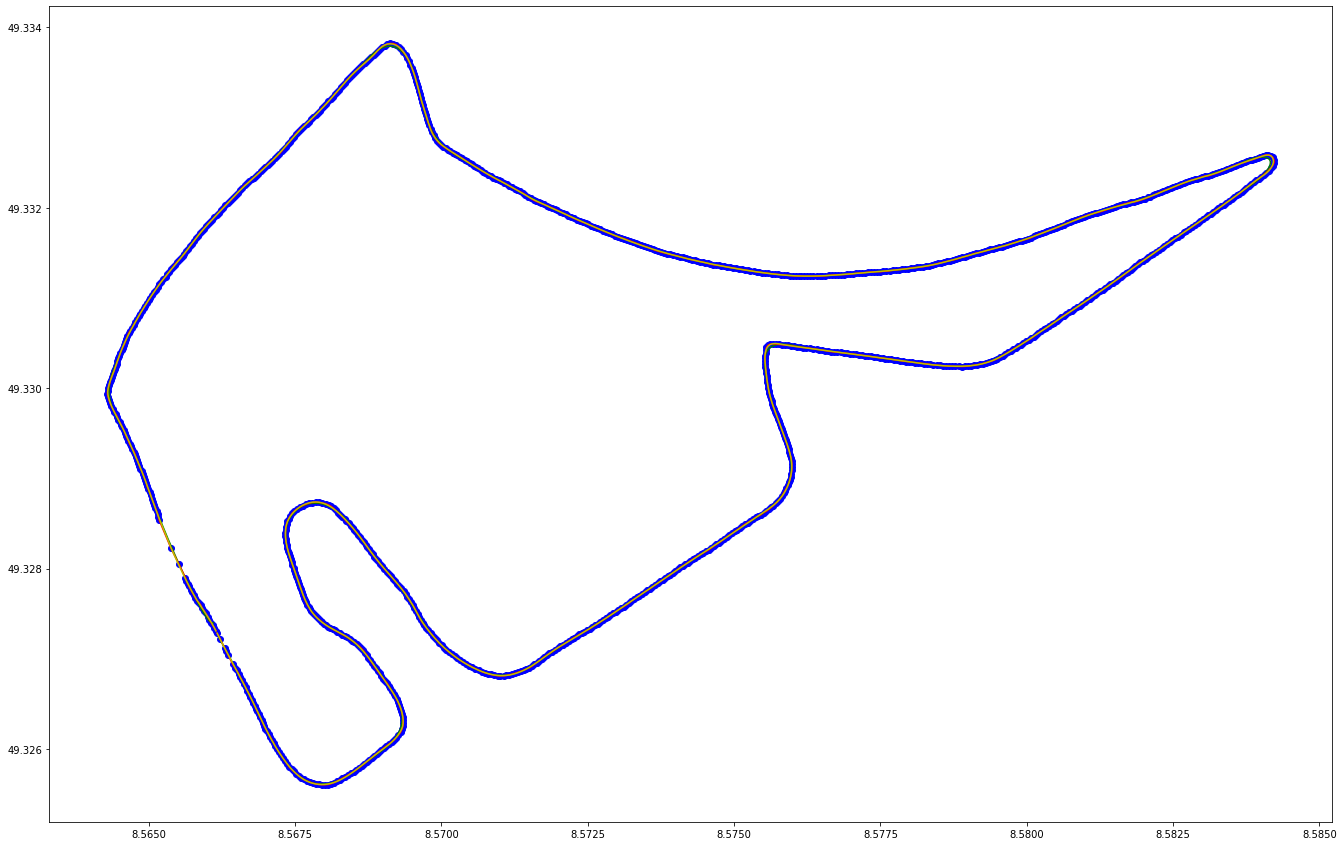

In [343]:
from scipy.interpolate import splprep, splev

tck, u = splprep([df['longitude'].values, df['latitude'].values], s=0)
new_points = splev(u, tck)
#print(len(new_points[0]), len(df['longitude'].values))

fig, ax = plt.subplots(figsize=(23,15))
ax.plot(df['longitude'].values, df['latitude'].values, 'bo')
ax.plot(df['lon_savgol'].values, df['lat_savgol'].values, 'g-')
ax.plot(new_points[0], new_points[1], 'r-')

tck, u = splprep([df['longitude'].values, df['latitude'].values], s=0.00000001)
new_points = splev(u, tck)
ax.plot(new_points[0], new_points[1], 'y-')

df['lat_bspline'] = new_points[1]
df['lon_bspline'] = new_points[0]


plt.show()

In [344]:
df

,latitude,longitude,elevation,time,srtm_ele,srtm_ele_built_in_smooth,srtm_ele_smoothed,ele_smoothed,ele_savgol,lat_savgol,lon_savgol,lat_bspline,lon_bspline
0,49.327311,8.566147,101.400002,2019-11-01 08:02:12+00:00,108,108.000000,108.00,101.400002,101.431316,49.327400,8.566102,49.327308,8.566144
1,49.327339,8.566121,101.400002,2019-11-01 08:02:13+00:00,108,107.705818,108.00,101.400002,101.440577,49.327396,8.566091,49.327339,8.566121
2,49.327369,8.566092,101.400002,2019-11-01 08:02:14+00:00,108,107.391396,108.00,101.400002,101.450134,49.327397,8.566078,49.327371,8.566095
3,49.327401,8.566064,101.400002,2019-11-01 08:02:15+00:00,108,107.060313,108.00,101.400002,101.459987,49.327402,8.566062,49.327403,8.566066
4,49.327434,8.566033,101.400002,2019-11-01 08:02:16+00:00,108,106.714673,108.00,101.400002,101.470135,49.327411,8.566044,49.327436,8.566036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,49.327044,8.566352,107.000000,2019-11-01 08:21:41+00:00,108,107.236600,104.06,107.211999,106.912303,49.327035,8.566365,49.327045,8.566354
1151,49.327081,8.566322,107.000000,2019-11-01 08:21:43+00:00,108,107.357124,104.16,107.195999,106.894924,49.327085,8.566324,49.327083,8.566323
1152,49.327119,8.566293,107.000000,2019-11-01 08:21:44+00:00,108,107.476891,104.26,107.179998,106.877407,49.327136,8.566281,49.327120,8.566294
1153,49.327220,8.566217,107.000000,2019-11-01 08:21:47+00:00,108,107.795615,104.36,107.163998,106.859750,49.327189,8.566237,49.327218,8.566215


## Export Processed GPX

In [345]:
# Creating a new file:
# --------------------

gpx_out = gpxpy.gpx.GPX()

gpx_out.name = 'Hockenheimring F1 Track - Smoothed V2'

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx_out.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:

#gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(x['latitude'], x['longitude'], elevation=x['ele_smoothed']))

df.apply(lambda x: gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(x['lat_bspline'], x['lon_bspline'], elevation=x['ele_savgol'])), axis=1)

#print('Created GPX:', gpx_out.to_xml())

print('Writing GPX file...')

gpx_file_out = open('hockenheimring-magic-road-processed.GPX', 'w')
gpx_file_out.write(gpx_out.to_xml())

Writing GPX file...


133104